In [80]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [81]:
# Modules
from modules.connector import MyBigQuery, MySQL

bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [95]:
def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2Compliance = row.co2Compliance * total_trading_diff_perc
    
        return co2Compliance
    else:
        return row.co2Compliance


# Latest Compliance

In [204]:
mandate = 0.1

In [205]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [206]:
van_targets = bq.from_bq_to_dataframe(
query = """
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make
""")

In [207]:
# %%bigquery van_targets --project rugged-baton-283921
# SELECT make, AVG(co2Emissions) as co2Target
# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
# AND monthOfFirstRegistration > '2020-12-31'
# AND monthOfFirstRegistration < '2022-01-01'
# AND co2Emissions > 0
# GROUP BY make

In [208]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [239]:
# df_activity = bq.from_bq_to_dataframe(
# query = """
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
# AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
#     AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;
# """
# )

In [254]:


df_activity = bq.from_bq_to_dataframe(
query = """
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;
"""
)

In [255]:
# %%bigquery df_activity --project rugged-baton-283921
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;

In [256]:
dfa = df_activity.merge(van_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [257]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
        return co2ComplianceAdj
    else:
        return row.co2Compliance



In [258]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [259]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances
0,MAN,2695,2622,69,635310.0,543.085422,1.423970e+06,7.886600e+05,67.375
1,RENAULT TRUCKS,2835,1426,93,810038.0,504.247436,7.190568e+05,-9.098116e+04,0.000
2,LAND ROVER,3233,3233,0,742815.0,243.048611,7.857762e+05,4.296116e+04,80.825
3,FIAT,4061,3790,271,727346.0,213.252940,8.082286e+05,8.088264e+04,101.525
4,IVECO,4129,3216,6,974709.0,558.126724,1.794936e+06,8.202265e+05,103.225
5,MAXUS,4188,1764,2418,478857.0,303.998630,5.362536e+05,5.739658e+04,104.700
6,ISUZU,4265,4260,0,969683.0,268.663642,1.144507e+06,1.748241e+05,106.625
7,NISSAN,4845,4399,52,979850.0,230.811389,1.015339e+06,3.548930e+04,121.125
8,TOYOTA,13006,11860,1144,2485643.0,220.205912,2.611642e+06,1.259991e+05,325.150
9,PEUGEOT,19391,16196,3180,3073842.0,183.069266,2.964990e+06,-1.088522e+05,0.000


In [260]:
# mandate = .1 Defined above
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [261]:
(1 - (mandate * .25)) * 135525

132136.875

In [262]:
dfa[dfa.make == 'VOLKSWAGEN']

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
14,VOLKSWAGEN,28749,28286,463,5518463.0,201.449585,5.698203e+06,179739.953932,718.725,25874.1,-2411.9,-1693.175


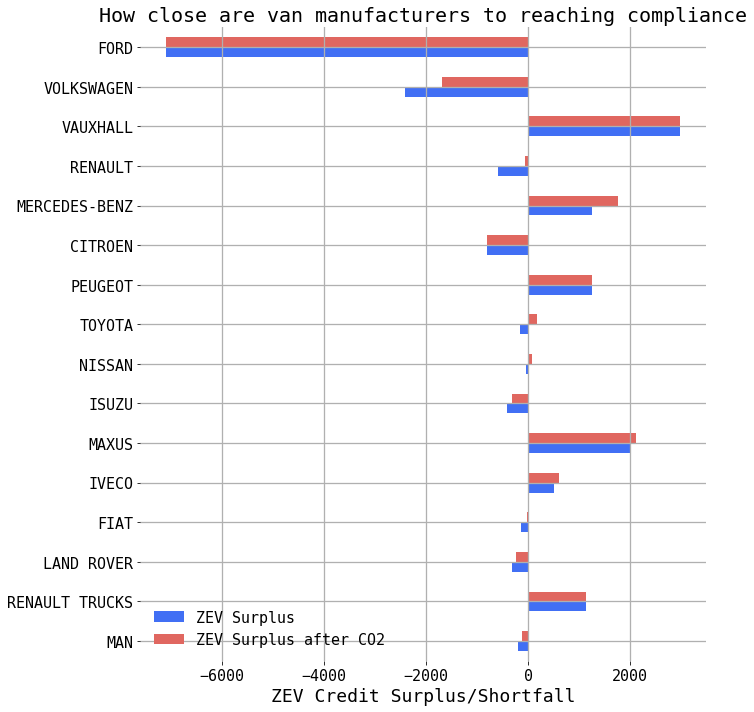

In [263]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('How close are van manufacturers to reaching compliance')

plt.savefig('plots/van_top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [264]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [265]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [266]:
dfa_sel.to_csv('van_ZEV_compliance_tracker.csv')

In [267]:
dfa_sel['Allowance Surplus'].sum()

-3080.0999999999995

# Rolling Performance

In [268]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 603/603 [00:00<00:00, 733.60rows/s] 


In [269]:
df_act

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
3,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
4,LAND ROVER,2020-05-01 00:00:00+00:00,24,24,0,4844.0
...,...,...,...,...,...,...
598,FORD,2022-09-01 00:00:00+00:00,13061,12769,292,2785599.0
599,FORD,2023-03-01 00:00:00+00:00,15275,14834,293,3149262.0
600,FORD,2022-03-01 00:00:00+00:00,16557,16554,3,3485470.0
601,FORD,2020-09-01 00:00:00+00:00,18152,18152,0,3095238.0


In [270]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [271]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [272]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
3,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
4,LAND ROVER,2020-05-01 00:00:00+00:00,24,24,0,4844.0


In [273]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [274]:
df

,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make
11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER
12,2021-04-01 00:00:00+00:00,1831.0,1829.0,2.0,409892.0,LAND ROVER
13,2021-05-01 00:00:00+00:00,2098.0,2096.0,2.0,475572.0,LAND ROVER
14,2021-06-01 00:00:00+00:00,2312.0,2309.0,3.0,531843.0,LAND ROVER
15,2021-07-01 00:00:00+00:00,2446.0,2443.0,3.0,571423.0,LAND ROVER
...,...,...,...,...,...,...
33,2023-01-01 00:00:00+00:00,20555.0,17849.0,1947.0,5517981.0,MERCEDES-BENZ
34,2023-02-01 00:00:00+00:00,20153.0,17419.0,1786.0,5151159.0,MERCEDES-BENZ
35,2023-03-01 00:00:00+00:00,20431.0,17495.0,1455.0,4870038.0,MERCEDES-BENZ
36,2023-04-01 00:00:00+00:00,20522.0,17346.0,1481.0,4674080.0,MERCEDES-BENZ


In [275]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(van_targets, how='left', on='make')

In [276]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [277]:
dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply
    
    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs.append(tdf)

<ipython-input-277-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-277-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-277-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is t

In [278]:
df = pd.concat(dfs)

In [279]:

df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [280]:
df.head()

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances
0,11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER,243.048611,3.414833e+05,35376.298611,34935.761803,35.175
49,11,2021-03-01 00:00:00+00:00,3033.0,2932.0,101.0,1015363.0,MAN,543.085422,1.592326e+06,576963.456760,569778.599964,75.825
76,11,2021-03-01 00:00:00+00:00,9449.0,9446.0,3.0,1754384.0,TOYOTA,220.205912,2.080065e+06,325681.040735,321625.373758,236.225
103,11,2021-03-01 00:00:00+00:00,12709.0,11435.0,1274.0,2017678.0,RENAULT,215.640899,2.465854e+06,448175.674782,442594.596804,317.725
130,11,2021-03-01 00:00:00+00:00,1607.0,1594.0,13.0,389459.0,RENAULT TRUCKS,504.247436,8.037704e+05,414311.413732,409152.043339,40.175


In [281]:
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [282]:
df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')

make,CITROEN,FIAT,FORD,ISUZU,IVECO,LAND ROVER,MAN,MAXUS,MERCEDES-BENZ,NISSAN,PEUGEOT,RENAULT,RENAULT TRUCKS,TOYOTA,VAUXHALL,VOLKSWAGEN
monthOfFirstRegistration,,,,,,,,,,,,,,,,
2021-03-01 00:00:00+00:00,585.075000,132.075000,2582.700000,65.500000,62.750000,35.175000,7.582500e+01,NaN,8.010750e+02,2.531250e+02,626.550000,3.177250e+02,40.175,236.225000,0.000000e+00,825.175000
2021-04-01 00:00:00+00:00,644.650000,144.525000,2815.350000,72.600000,70.100000,45.775000,8.282500e+01,NaN,8.405000e+02,2.815250e+02,678.325000,3.428750e+02,43.300,263.775000,0.000000e+00,894.275000
2021-05-01 00:00:00+00:00,700.975000,153.425000,2988.150000,78.325000,78.800000,52.450000,8.642500e+01,NaN,8.582750e+02,3.040250e+02,716.275000,3.721000e+02,46.850,284.700000,0.000000e+00,958.800000
2021-06-01 00:00:00+00:00,690.550000,157.275000,2961.400000,83.175000,89.800000,57.800000,8.822500e+01,NaN,8.467750e+02,3.023000e+02,725.950000,4.015750e+02,50.325,289.500000,0.000000e+00,994.450000
2021-07-01 00:00:00+00:00,686.025000,154.900000,2957.875000,81.750000,96.250000,61.150000,8.767500e+01,NaN,8.137250e+02,2.961500e+02,716.125000,3.860500e+02,52.300,282.325000,0.000000e+00,985.625000
2021-08-01 00:00:00+00:00,684.975000,152.475000,3038.775000,83.525000,0.000000,62.900000,8.177500e+01,0.000000,7.652000e+02,2.978250e+02,695.275000,3.783500e+02,53.250,294.275000,0.000000e+00,978.625000
2021-09-01 00:00:00+00:00,625.475000,43.198280,2876.175000,80.725000,0.000000,65.675000,7.830000e+01,0.000000,7.707500e+02,2.683750e+02,641.525000,3.809500e+02,52.550,300.625000,0.000000e+00,894.625000
2021-10-01 00:00:00+00:00,638.375000,0.000000,2925.050000,79.675000,0.000000,49.570318,7.335000e+01,0.000000,7.488750e+02,2.553153e+02,644.575000,3.897250e+02,54.525,298.568455,9.838435e+01,844.925000
2021-11-01 00:00:00+00:00,578.418635,0.000000,2666.230685,8.978276,0.000000,16.091900,5.066502e+00,0.000000,7.359250e+02,1.828407e+02,508.521217,2.676998e+02,55.450,118.973576,3.418587e+02,646.087220


In [283]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

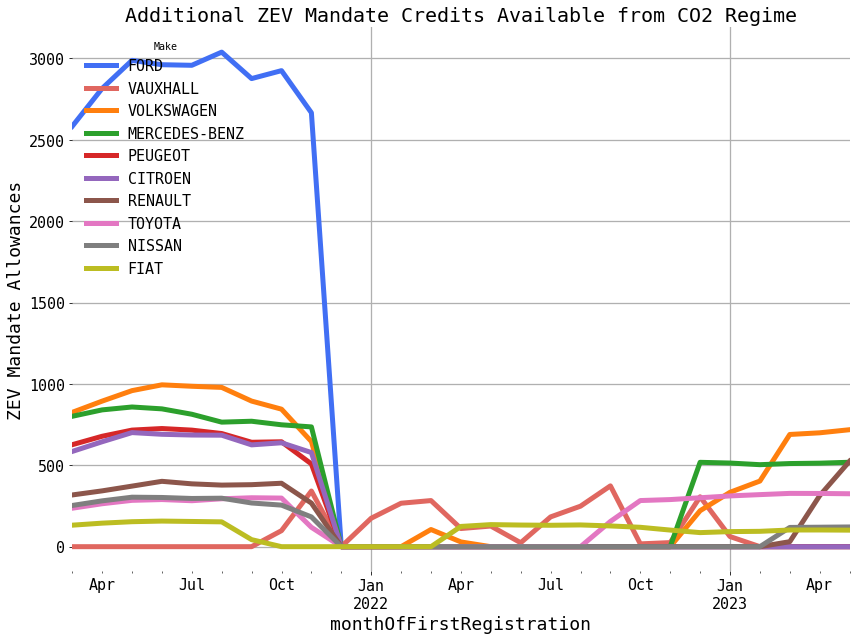

In [284]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

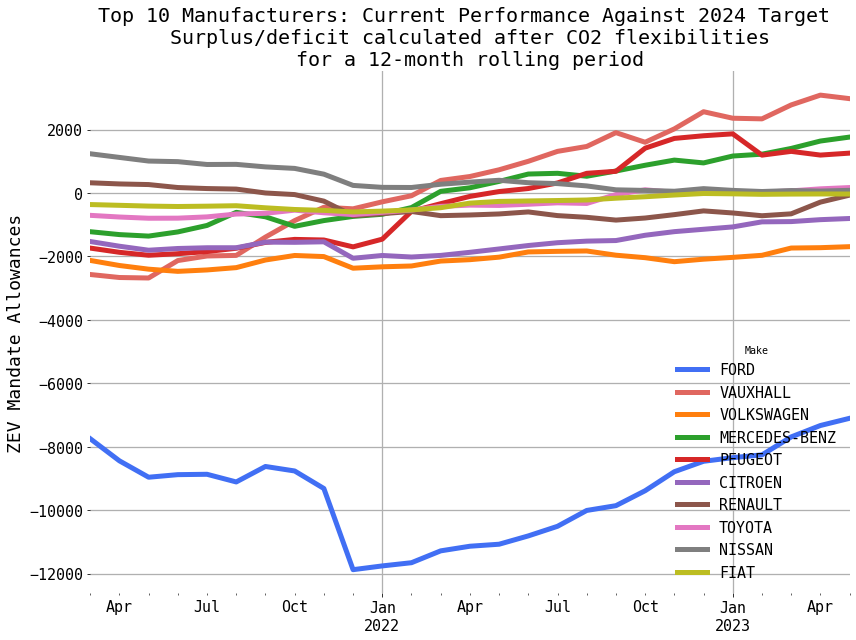

In [285]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

# plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [286]:
dfa['ZEV Surplus after CO2']

0     -129.125
1     1125.500
2     -242.475
3      -33.575
4      603.325
5     2109.900
6     -314.875
7       82.625
8      170.550
9     1255.900
10    -804.900
11    1762.050
12     -68.600
13    2973.500
14   -1693.175
15   -7103.600
Name: ZEV Surplus after CO2, dtype: float64

<AxesSubplot:xlabel='monthOfFirstRegistration'>

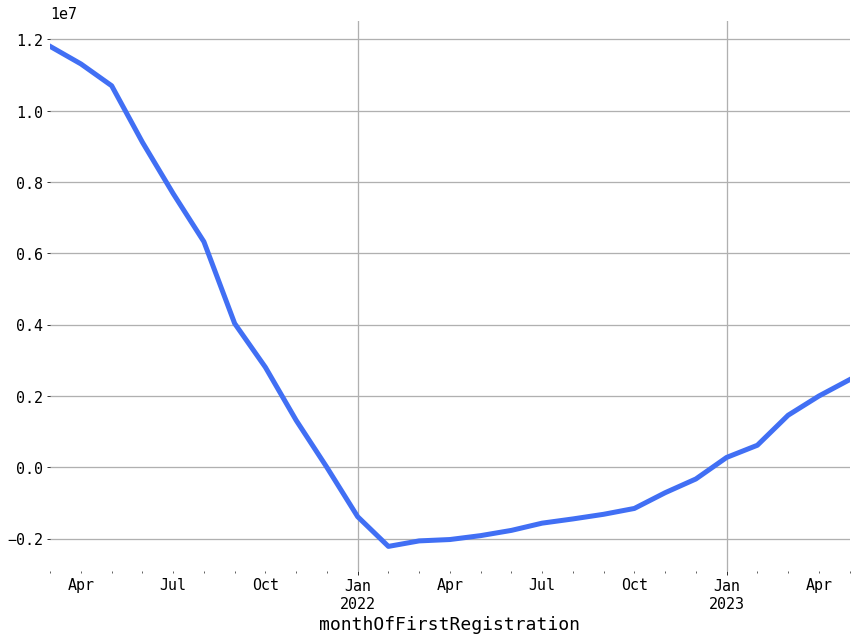

In [287]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

In [288]:
df

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
0,11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER,243.048611,3.414833e+05,3.537630e+04,34935.761803,35.175,1266.3,-138.7,-103.525
49,11,2021-03-01 00:00:00+00:00,3033.0,2932.0,101.0,1015363.0,MAN,543.085422,1.592326e+06,5.769635e+05,569778.599964,75.825,2729.7,-202.3,-126.475
76,11,2021-03-01 00:00:00+00:00,9449.0,9446.0,3.0,1754384.0,TOYOTA,220.205912,2.080065e+06,3.256810e+05,321625.373758,236.225,8504.1,-941.9,-705.675
103,11,2021-03-01 00:00:00+00:00,12709.0,11435.0,1274.0,2017678.0,RENAULT,215.640899,2.465854e+06,4.481757e+05,442594.596804,317.725,11438.1,3.1,320.825
130,11,2021-03-01 00:00:00+00:00,1607.0,1594.0,13.0,389459.0,RENAULT TRUCKS,504.247436,8.037704e+05,4.143114e+05,409152.043339,40.175,1446.3,-147.7,-107.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,37,2023-05-01 00:00:00+00:00,28749.0,28286.0,463.0,5518463.0,VOLKSWAGEN,201.449585,5.698203e+06,1.797400e+05,114893.873608,718.725,25874.1,-2411.9,-1693.175
345,37,2023-05-01 00:00:00+00:00,19771.0,18599.0,1131.0,3554000.0,CITROEN,180.890005,3.364373e+06,-1.896268e+05,-189626.798500,0.000,17793.9,-805.1,-805.100
372,37,2023-05-01 00:00:00+00:00,26570.0,20940.0,5622.0,3995761.0,VAUXHALL,190.110223,3.980908e+06,-1.485294e+04,-14852.939493,0.000,23913.0,2973.0,2973.000
399,37,2023-05-01 00:00:00+00:00,100326.0,97397.0,2497.0,20781849.0,FORD,203.276128,1.979849e+07,-9.833639e+05,-983363.924082,0.000,90293.4,-7103.6,-7103.600


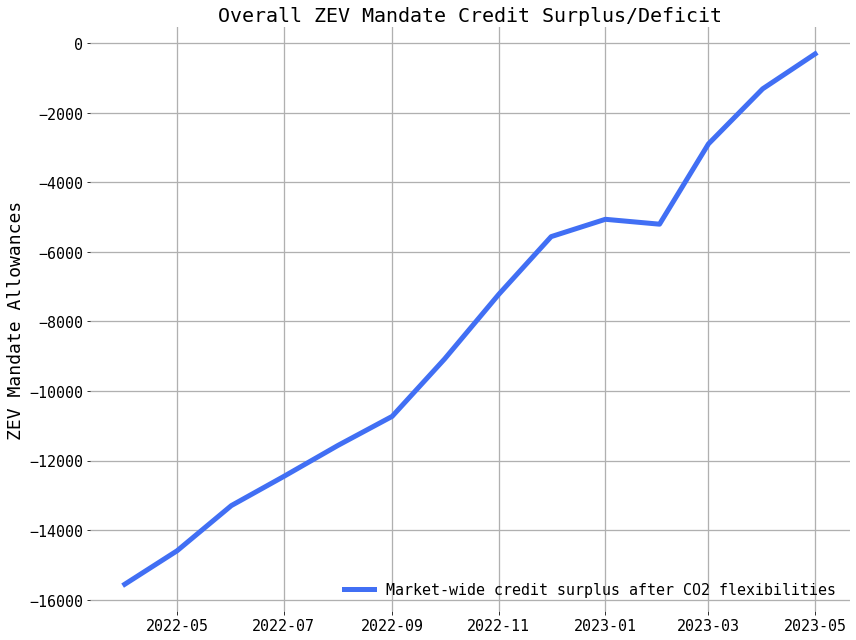

In [289]:
fig, ax = plt.subplots()

plt_df = df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(plt_df[plt_df.index > '2022-03-01'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Credit Surplus/Deficit')

plt.savefig('plots/van_aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [291]:
round(plt_df, ndigits=0)

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -17148.0
2021-04-01 00:00:00+00:00   -18806.0
2021-05-01 00:00:00+00:00   -19992.0
2021-06-01 00:00:00+00:00   -19391.0
2021-07-01 00:00:00+00:00   -18997.0
2021-08-01 00:00:00+00:00   -18135.0
2021-09-01 00:00:00+00:00   -16732.0
2021-10-01 00:00:00+00:00   -16366.0
2021-11-01 00:00:00+00:00   -16711.0
2021-12-01 00:00:00+00:00   -21335.0
2022-01-01 00:00:00+00:00   -20344.0
2022-02-01 00:00:00+00:00   -18760.0
2022-03-01 00:00:00+00:00   -16636.0
2022-04-01 00:00:00+00:00   -15556.0
2022-05-01 00:00:00+00:00   -14591.0
2022-06-01 00:00:00+00:00   -13294.0
2022-07-01 00:00:00+00:00   -12455.0
2022-08-01 00:00:00+00:00   -11564.0
2022-09-01 00:00:00+00:00   -10729.0
2022-10-01 00:00:00+00:00    -9079.0
2022-11-01 00:00:00+00:00    -7221.0
2022-12-01 00:00:00+00:00    -5561.0
2023-01-01 00:00:00+00:00    -5063.0
2023-02-01 00:00:00+00:00    -5203.0
2023-03-01 00:00:00+00:00    -2894.0
2023-04-01 00:00:00+00:00    -1312.0
2023-05-01 00

In [40]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [41]:
van_targets[van_targets.make.isin(top_makes)]

,make,co2Target
0,FORD,203.276128
1,NISSAN,230.811389
3,RENAULT,215.640899
25,VAUXHALL,190.110223
26,FIAT,213.252940
27,VOLKSWAGEN,201.449585
35,PEUGEOT,183.069266
36,CITROEN,180.890005
39,MERCEDES-BENZ,342.802860
49,TOYOTA,220.205912


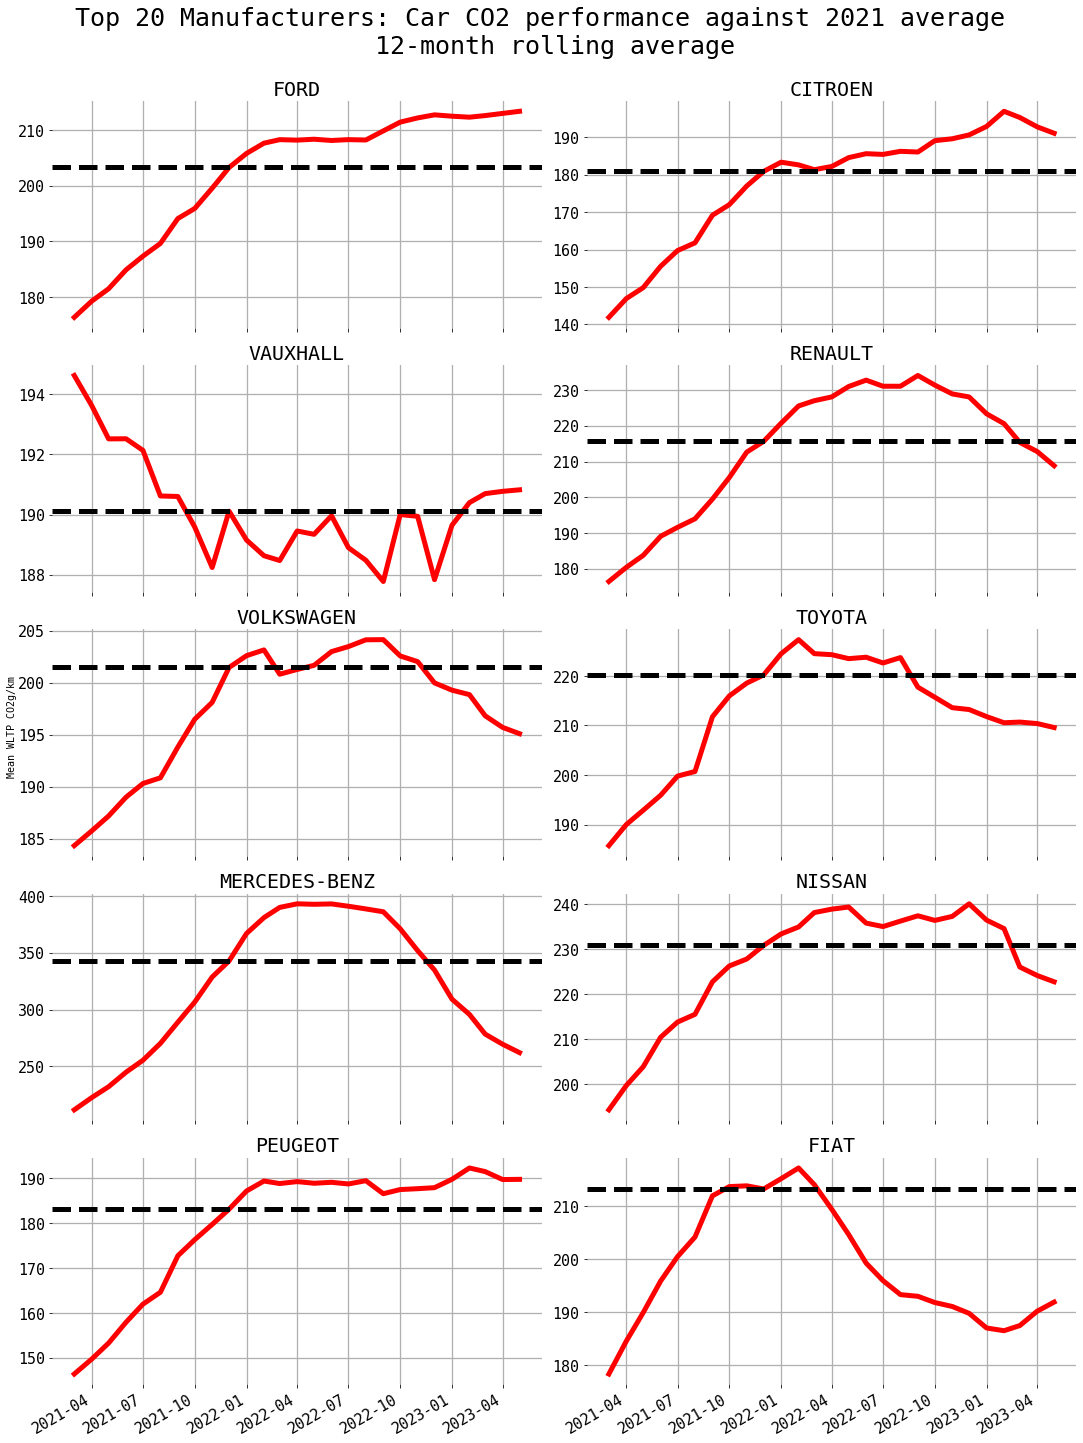

In [42]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/van_co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [79]:
df

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
0,11,2021-03-01 00:00:00+00:00,1407.0,1405.0,2.0,306107.0,LAND ROVER,243.048611,3.414833e+05,3.537630e+04,34935.761803,35.175000,1266.3,-138.7,-103.525000
49,11,2021-03-01 00:00:00+00:00,3033.0,2932.0,101.0,1015363.0,MAN,543.085422,1.592326e+06,5.769635e+05,569778.599964,75.825000,2729.7,-202.3,-126.475000
76,11,2021-03-01 00:00:00+00:00,9449.0,9446.0,3.0,1754384.0,TOYOTA,220.205912,2.080065e+06,3.256810e+05,321625.373758,236.225000,8504.1,-941.9,-705.675000
103,11,2021-03-01 00:00:00+00:00,12709.0,11435.0,1274.0,2017678.0,RENAULT,215.640899,2.465854e+06,4.481757e+05,442594.596804,317.725000,11438.1,3.1,320.825000
130,11,2021-03-01 00:00:00+00:00,1607.0,1594.0,13.0,389459.0,RENAULT TRUCKS,504.247436,8.037704e+05,4.143114e+05,409152.043339,40.175000,1446.3,-147.7,-107.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,37,2023-05-01 00:00:00+00:00,28749.0,28286.0,463.0,5518463.0,VOLKSWAGEN,201.449585,5.698203e+06,1.797400e+05,114893.873608,531.916082,25874.1,-2411.9,-1879.983918
345,37,2023-05-01 00:00:00+00:00,19771.0,18599.0,1131.0,3554000.0,CITROEN,180.890005,3.364373e+06,-1.896268e+05,-189626.798500,0.000000,17793.9,-805.1,-805.100000
372,37,2023-05-01 00:00:00+00:00,26570.0,20940.0,5622.0,3995761.0,VAUXHALL,190.110223,3.980908e+06,-1.485294e+04,-14852.939493,0.000000,23913.0,2973.0,2973.000000
399,37,2023-05-01 00:00:00+00:00,100326.0,97397.0,2497.0,20781849.0,FORD,203.276128,1.979849e+07,-9.833639e+05,-983363.924082,0.000000,90293.4,-7103.6,-7103.600000
